
## 🔧 Шаг 0: Установка зависимостей


In [2]:
!pip install torch torch-geometric pandas scikit-learn


## 📥 Шаг 1: Загрузка и первичная обработка данных


In [1]:
import pandas as pd

# Загрузка датасета
df = pd.read_csv('../data/processing/df_preprocessing.csv')



In [2]:
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler

#numeric_features = ['log_TransactionAmt', 'Transaction_hour', 'Transaction_weekday']
#categorical_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'DeviceType', 'DeviceInfo']

# Числовые и категориальные признаки
numeric_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

#base_train = df.copy()



# Легкая предобработка
for col in categorical_features:
    #base_train[col] = base_train[col].fillna('unknown')
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


# Преобразование временных признаков
df['hour_sin'] = np.sin(2 * np.pi * df['Transaction_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Transaction_hour'] / 24)

df['weekday_sin'] = np.sin(2 * np.pi * df['Transaction_weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['Transaction_weekday'] / 7)

df['Transaction_day_norm'] = df['Transaction_day'] / df['Transaction_day'].max()



# 2. Обработка числовых признаков (заполнение пропусков медианой)
#scaler = StandardScaler()
#base_train[numeric_features] = scaler.fit_transform(base_train[numeric_features])


df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,Transaction_hour,Transaction_weekday,log_TransactionAmt,TransactionAmt_binned,isOutlier,hour_sin,hour_cos,weekday_sin,weekday_cos,Transaction_day_norm
0,2987002,0,86469,59.0,4,8721,389,41,3,58,...,0,0,4.094345,2,0,0.0,1.0,0.0,1.0,0.0
1,2987004,0,86506,50.0,1,8608,413,41,2,2,...,0,0,3.931826,2,0,0.0,1.0,0.0,1.0,0.0
2,2987005,0,86510,49.0,4,9617,454,41,3,106,...,0,0,3.912023,2,0,0.0,1.0,0.0,1.0,0.0
3,2987006,0,86522,159.0,4,1860,259,41,3,58,...,0,0,5.075174,3,0,0.0,1.0,0.0,1.0,0.0
4,2987008,0,86535,15.0,1,7405,0,41,3,106,...,0,0,2.772589,2,0,0.0,1.0,0.0,1.0,0.0


In [3]:
df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'Transaction_hour', 'Transaction_weekday', 'log_TransactionAmt',
       'TransactionAmt_binned', 'isOutlier', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'Transaction_day_norm'],
      dtype='object', length=214)

In [4]:
X = df.drop(labels=['TransactionID', 'TransactionDT', 'Relative_TransactionDT', 'TransactionAmt', 'isOutlier',  'isFraud'], axis=1)
y = df['isFraud']

In [112]:
# Целевая переменная
target_column = "isFraud"

# Выбор подмножества признаков (можно расширить)
selected_features = [
    'hour_sin', 'hour_cos',
    'weekday_sin', 'weekday_cos',
    'Transaction_day_norm',
    "TransactionAmt", 
    "card1", "card2", "card3", "card4", 
    "addr1", "addr2", 
    "C1", "C2", "D1", "D4"
]

# Удаление строк с пропущенными значениями
df = df[[target_column] + selected_features].dropna().reset_index(drop=True)

## ⚙️ Шаг 2: Нормализация признаков

In [ ]:
#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#features = scaler.fit_transform(df[selected_features])
#labels = df[target_column].values

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(X)
labels = y.values

## 🕸️ Шаг 3: Построение графа

In [6]:
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

# Количество ближайших соседей
k = 5

# Построение KNN-графа
knn = NearestNeighbors(n_neighbors=k + 1)
knn.fit(features)
distances, indices = knn.kneighbors(features)

# Создание ребер (без самих себя)
edge_index = []
for i in range(len(indices)):
    for j in indices[i][1:]:  # исключаем самого себя
        edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

In [7]:
data

Data(x=[395677, 208], edge_index=[2, 1978385], y=[395677])

In [8]:
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([395677, 208])
tensor([[ 0.6876,  0.6212,  0.7866,  ...,  0.0634,  1.3464, -1.6589],
        [-1.2376,  0.5904,  0.9391,  ...,  0.0634,  1.3464, -1.6589],
        [ 0.6876,  0.8653,  1.1994,  ...,  0.0634,  1.3464, -1.6589],
        ...,
        [ 0.6876, -1.3063,  1.4535,  ..., -1.0669,  0.8237,  1.6927],
        [ 0.6876,  1.2388,  0.7295,  ..., -1.0669,  0.8237,  1.6927],
        [ 0.6876, -0.6558, -1.2456,  ..., -1.0669,  0.8237,  1.6927]])


In [9]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 1978385])
tensor([[     0,      0,      0,  ..., 395676, 395676, 395676],
        [ 31560,  31706,  12717,  ..., 188126, 350828, 268551]])


In [10]:
#from torch_geometric.utils import to_dense_adj

#A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
#print(f'A = {A.shape}')
#print(A)

In [11]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([395677])
tensor([0, 0, 0,  ..., 0, 0, 0])


In [12]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

In [13]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


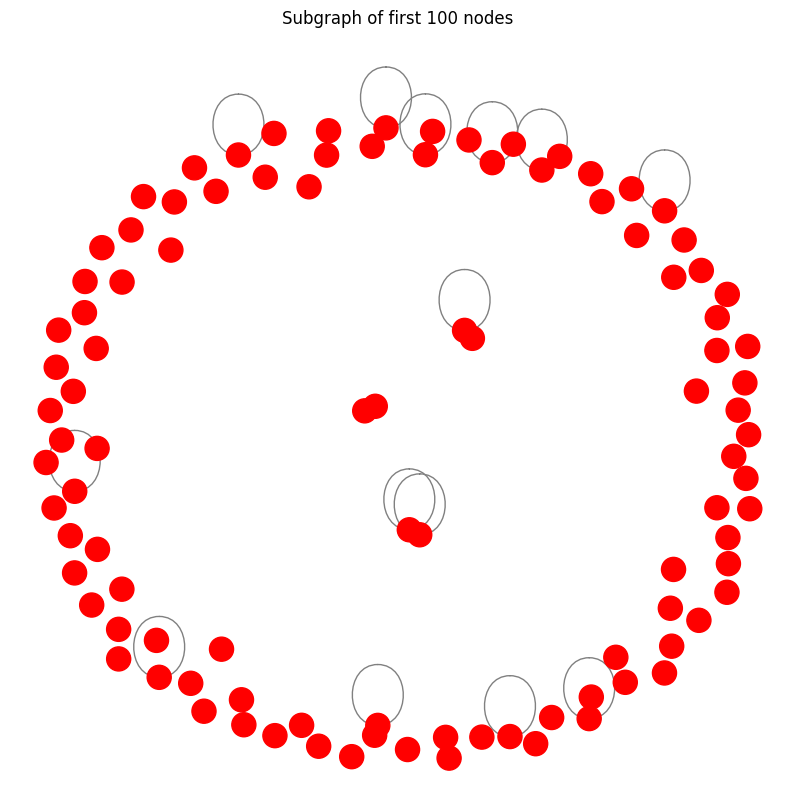

In [79]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Количество узлов для визуализации
N = 100

# Получаем весь граф
G_full = to_networkx(data, to_undirected=True)

# Получаем только первые N узлов
subset_nodes = list(range(N))

# Строим подграф
G_sub = G_full.subgraph(subset_nodes)

# Позиции узлов
pos = nx.spring_layout(G_sub, seed=42)

# Цвета узлов по меткам (data.y)
node_colors = data.y[subset_nodes].cpu().numpy()

# Отрисовка
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G_sub,
                 pos=pos,
                 node_size=300,
                 node_color=node_colors,
                 cmap="hsv",
                 with_labels=False,
                 edge_color="gray"
                )
plt.title(f"Subgraph of first {N} nodes")
plt.show()


In [80]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Получаем весь граф
G_full = to_networkx(data, to_undirected=True)

# Находим индексы мошенников
fraud_indices = (data.y == 1).nonzero(as_tuple=True)[0].cpu().numpy()


# Строим подграф только для мошенников
G_fraud = G_full.subgraph(fraud_indices)

# Позиции узлов
pos = nx.spring_layout(G_fraud, seed=42)

# Цвета — одинаковые (все y == 1), но можно оставить для универсальности
node_colors = data.y[fraud_indices].cpu().numpy()

# Визуализация
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G_fraud,
                 pos=pos,
                 node_size=300,
                 node_color=node_colors,
                 cmap="Reds",
                 with_labels=False,
                 edge_color="gray")
plt.title("Subgraph: Fraudulent Nodes Only (isFraud == 1)")
plt.show()


KeyboardInterrupt: 

KeyboardInterrupt: 

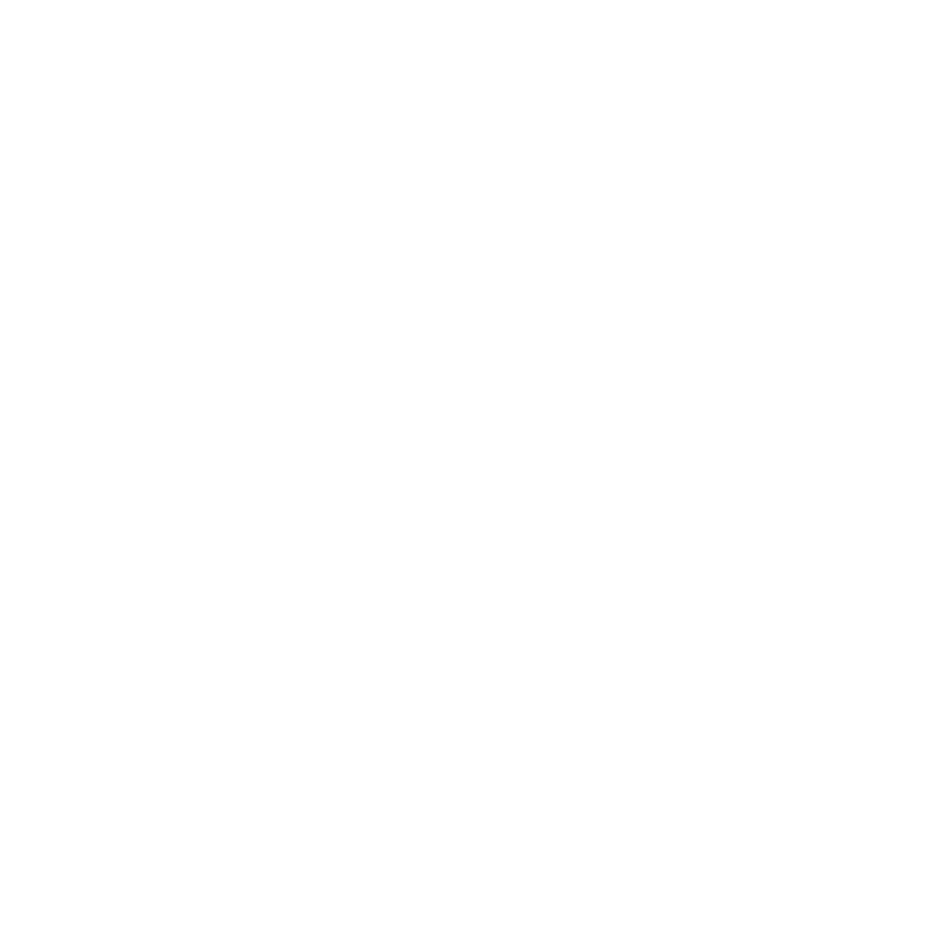

In [ ]:
 #from torch_geometric.utils import to_networkx
 #import matplotlib.pyplot as plt
 #import seaborn as sns
 #import networkx as nx
 #
 #G = to_networkx(data, to_undirected=True)
 #plt.figure(figsize=(12,12))
 #plt.axis('off')
 #nx.draw_networkx(G,
 #                pos=nx.spring_layout(G, seed=0),
 #                with_labels=True,
 #                node_size=800,
 #                node_color=data.y,
 #                cmap="hsv",
 #                vmin=-2,
 #                vmax=3,
 #                width=0.8,
 #                edge_color="grey",
 #                font_size=14
 #                )
 #plt.show()

## 🧪 Шаг 4: Разделение на обучающую и тестовую выборки


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

train_mask = torch.zeros(len(df), dtype=torch.bool)
test_mask = torch.zeros(len(df), dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.test_mask = test_mask

## 🧠 Шаг 5: Определение модели `SimpleGNN`

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()

In [16]:
class GCNWithLinear(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x.squeeze()


## 🏋️ Шаг 6: Обучение модели

In [17]:
# 🔁 Обучение
def train(model, data, epochs=100, lr=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask].float())
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_simple_gnn = SimpleGNN(input_dim=x.shape[1], hidden_dim=32).to(device)
data = data.to(device)

train(model=model_simple_gnn, data=data, epochs=100, lr=0.01)

Epoch 0, Loss: 0.9452
Epoch 10, Loss: 0.1601
Epoch 20, Loss: 0.1522
Epoch 30, Loss: 0.1400
Epoch 40, Loss: 0.1316
Epoch 50, Loss: 0.1282
Epoch 60, Loss: 0.1262
Epoch 70, Loss: 0.1246
Epoch 80, Loss: 0.1235
Epoch 90, Loss: 0.1225


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn_ln = GCNWithLinear(input_dim=x.shape[1], hidden_dim=32).to(device)
data = data.to(device)

train(model=model_gcn_ln, data=data, epochs=100, lr=0.01)

Epoch 0, Loss: 0.7023
Epoch 10, Loss: 0.1879
Epoch 20, Loss: 0.1465
Epoch 30, Loss: 0.1338
Epoch 40, Loss: 0.1293
Epoch 50, Loss: 0.1265
Epoch 60, Loss: 0.1247
Epoch 70, Loss: 0.1232
Epoch 80, Loss: 0.1219
Epoch 90, Loss: 0.1208


## 📈 Шаг 7: Оценка модели

In [29]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# 📊 Тест
@torch.no_grad()
def evaluate(model, data, name="Model"):
    model.eval()
    logits = model(data.x, data.edge_index)
    probs = torch.sigmoid(logits[data.test_mask])
    preds = (probs > 0.5).long()
    true = data.y[data.test_mask].long()

    # 🎯 ROC AUC
    fpr, tpr, _ = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # 🎯 PR AUC
    precision, recall, _ = precision_recall_curve(true, probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    return {
        "Accuracy": accuracy_score(true, preds),
        "F1": f1_score(true, preds),
        "AUC": roc_auc_score(true, probs),
        "Precision": precision_score(true, preds),
        "Recall": recall_score(true, preds)
    }

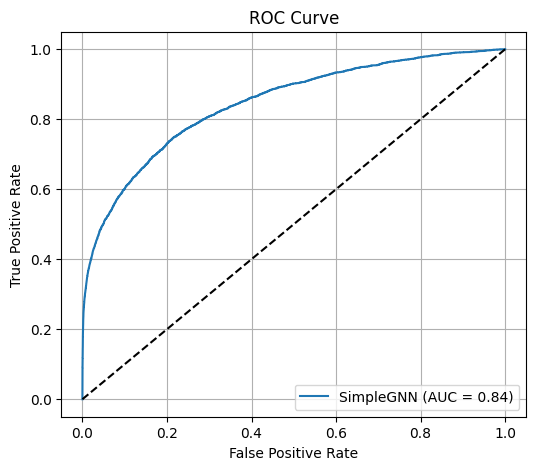

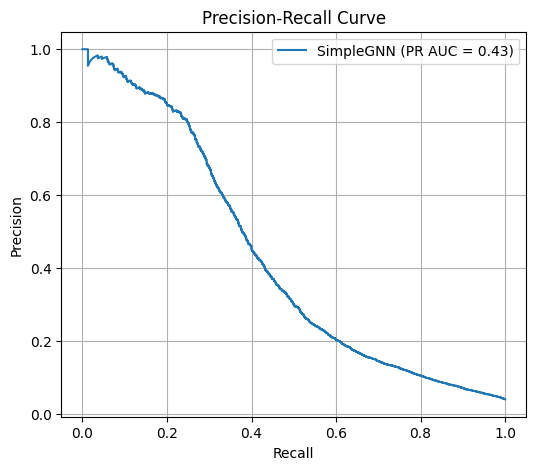

{'Accuracy': 0.966841892438334,
 'F1': 0.36372453928225024,
 'AUC': np.float64(0.844851337694148),
 'Precision': 0.8169934640522876,
 'Recall': 0.23393636930754835}

In [30]:
evaluate(model=model_simple_gnn, data=data, name='SimpleGNN')

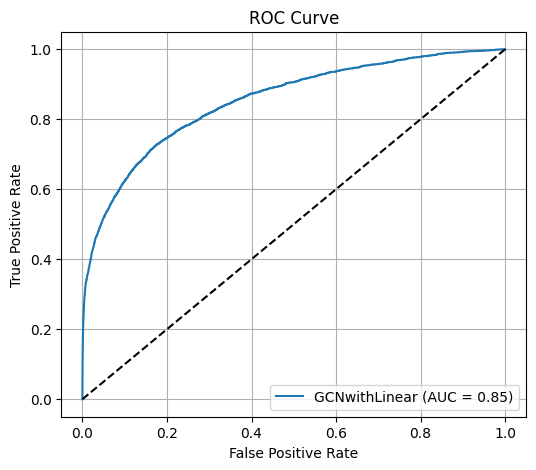

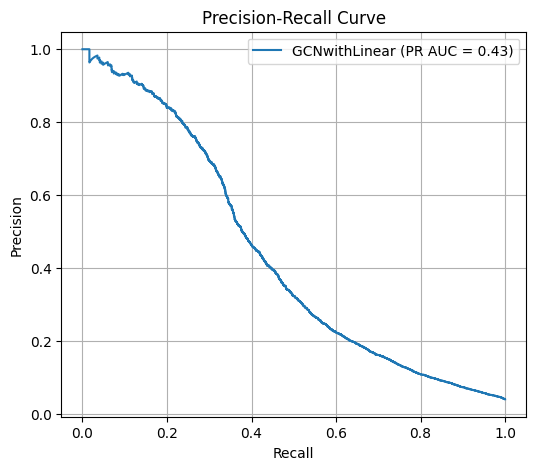

{'Accuracy': 0.9667155276991508,
 'F1': 0.3653012048192771,
 'AUC': np.float64(0.852584159376528),
 'Precision': 0.8029661016949152,
 'Recall': 0.2364316905801622}

In [31]:
evaluate(model=model_gcn_ln, data=data, name='GCNwithLinear')